In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib

In [19]:
df = pd.read_csv('cs_bisnode_panel.csv')

In [17]:
#Chunk de utilização do pywedge após a limpeza da base
#train = pd.read_csv('cs_bisnode_panel.csv')             #1 Base de dados utilizada
#mc = pw.Pywedge_Charts(train, c=None, y = 'birth_year') #2 Puxa os dados e faz o target em uma variavel específica 
#charts = mc.make_charts()                               #3 Cria os dados e gráficos @@@CUIDADO@@@ "Tempo de processamento"

/home/michelmcn/anaconda3/lib/python3.11/site-packages/pywedge/pywedge.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  self.X = self.train.drop(self.y,1)


#### Filtros:
Filtre para trabalhar apenas com empresas do ano de 2012
1 - Sales < 0 substituir por 0
Essa variável é bastante assimétrica, concorda? Será que vale criar novas
colunas que representem o valor emlo g dessa coluna?
Será que isso também se aplica para as demais?


In [5]:
# Contagem de Nulos
df.isnull()
null_count = df.isnull().sum()
print(null_count)


comp_id                      0
begin                        0
end                          0
COGS                    269572
amort                     8040
curr_assets                131
curr_liab                  131
extra_exp                18529
extra_inc                18529
extra_profit_loss        17203
finished_prod           270344
fixed_assets               131
inc_bef_tax               7437
intang_assets              140
inventories                131
liq_assets                 131
material_exp              8040
net_dom_sales           269572
net_exp_sales           269572
personnel_exp             8040
profit_loss_year          9884
sales                     7437
share_eq                   131
subscribed_cap             131
tang_assets               1470
wages                   269846
D                       287829
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             56457
exit_yea

## Pré Processamento
### 1- Drop das colunas

In [20]:
df = df.drop(columns=['COGS', 'finished_prod', 'net_dom_sales',
'net_exp_sales', 'wages', 'D'])


### 2- Instalar o pacote missingno para verificar o percentual de missings das features

<Axes: >

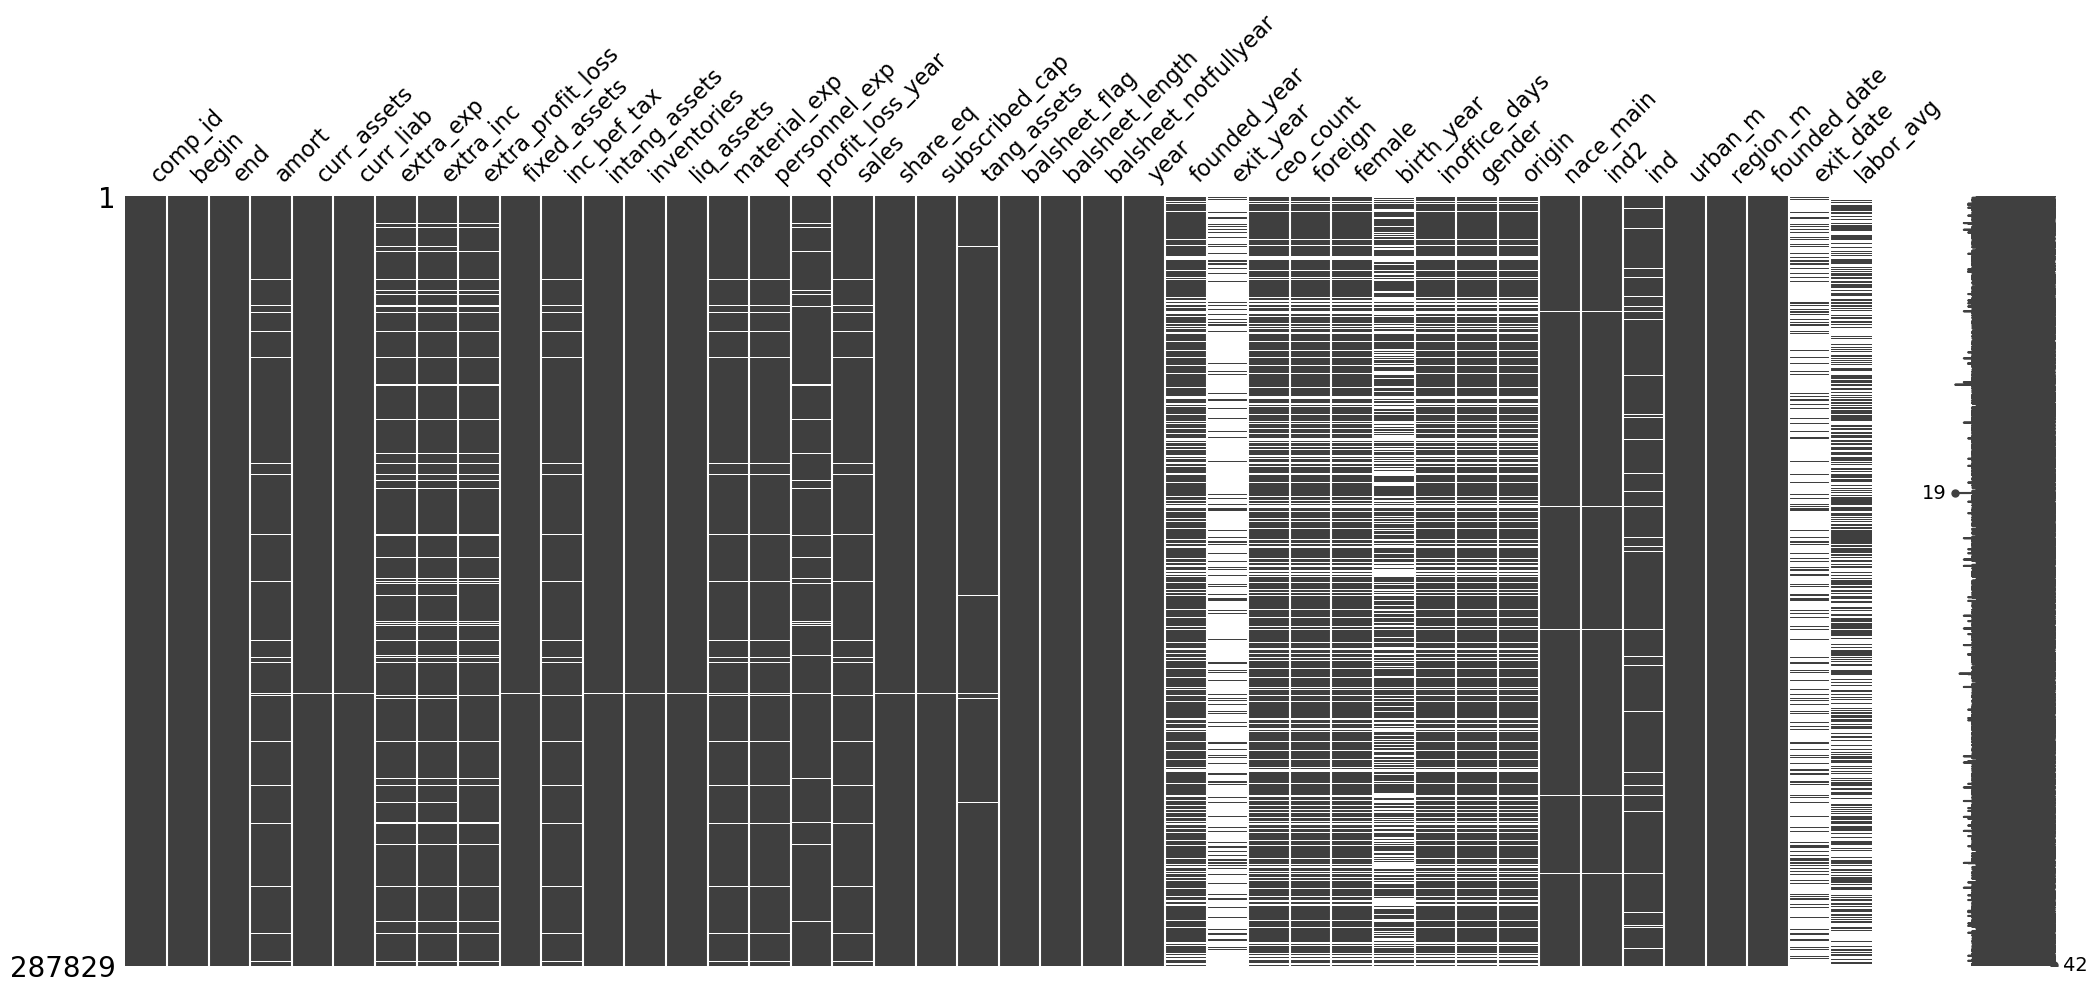

In [7]:
msno.matrix(df)

#### *Visualmente parece que as variáveis que apresentam missing values se coincidem no DF o que pode indicar algum grau de correlação.

### 3 - Remover os registros de 2016

In [21]:
df = df[df['year']!=2016]

In [23]:
#Cria uma coluna para verificar se a empresa esta ativa em 2012
df['Open_2012'] = df.groupby('comp_id')['year'].transform(lambda x: 2012 in x.values)

In [25]:
#Testando forma de como criar uma função para a coluna de empresas abertas em 2012
test = df[['comp_id', 'year', 'sales', 'Open_2012']].query('(year == 2012) and (sales > 0)')
test.groupby('comp_id')['sales'].sum()



comp_id
1.001541e+06    1.203704e+03
1.002029e+06    1.136515e+06
1.003200e+06    2.785185e+03
1.011889e+06    4.336667e+05
1.014183e+06    1.297296e+05
                    ...     
4.638854e+11    1.561481e+05
4.639820e+11    1.908296e+05
4.640212e+11    3.804815e+04
4.640446e+11    8.533974e+06
4.641050e+11    1.548778e+05
Name: sales, Length: 22845, dtype: float64

In [12]:
#Teste para contar quantas empresas estão abertas em 2012
test['comp_id'].nunique()

22845